In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [11]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from sklearn.model_selection import train_test_split
import albumentations as A
import cv2

In [6]:
# !unzip /kaggle/input/tgs-salt-identification-challenge/train.zip -d train_data
# !unzip /kaggle/input/tgs-salt-identification-challenge/test.zip -d test_data
image_dir = '/kaggle/working/train_data/images'
mask_dir = '/kaggle/working/train_data/masks'

In [50]:
image_filenames = sorted(os.listdir(image_dir))
train_files, val_files = train_test_split(
    image_filenames, test_size=0.2, random_state=42)
# %%
class SaltDataset(Dataset):
    def __init__(self, image_dir, mask_dir, file_list,transform=None): #image_transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.file_list = file_list
        # self.image_transform = image_transform
        # self.mask_transform = mask_transform
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_name = self.file_list[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L') # Normalize 16-bit mask to [0,1]
        # Convert to NumPy arrays for albumentations
        image = np.array(image)  # Shape: [H, W, 3]
        mask = np.array(mask) / 65535.0
        # if self.image_transform:
        #     image = self.image_transform(image)
        # if self.mask_transform:
        #     mask = self.mask_transform(mask)
            # Apply albumentations transform
        # Apply albumentations transform
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image, mask = augmented['image'], augmented['mask']
        
        # Ensure mask is [1, H, W]
        if len(mask.shape) == 2:
            mask = mask[np.newaxis, ...]
        return image, torch.tensor(mask, dtype=torch.float32)
        # return image, mask

In [51]:
# Define augmentations for training
train_transform = A.Compose([
    A.PadIfNeeded(128, 128, border_mode=cv2.BORDER_REFLECT),  # Pad to 128x128
    A.HorizontalFlip(p=0.5),  # 50% chance of horizontal flip
    A.RandomRotate90(p=0.5),  # 50% chance of 90-degree rotation
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=10, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Keep ImageNet normalization
    A.ToTensorV2(),  # Convert to PyTorch tensor
])

# Minimal transforms for validation
val_transform = A.Compose([
    A.PadIfNeeded(128, 128, border_mode=cv2.BORDER_REFLECT),  # Pad to 128x128
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    A.ToTensorV2(),
])

/tmp/ipykernel_31/64433176.py:8: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),


In [52]:
train_dataset = SaltDataset(image_dir, mask_dir, train_files, transform = train_transform)
val_dataset = SaltDataset(image_dir, mask_dir, val_files, transform = val_transform)

In [53]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch, dropout=0.0):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout)
        )
    def forward(self, x):
        return self.double_conv(x)


class Unet(nn.Module):
    def __init__(self):
        super(Unet, self).__init__()
        self.enc1 = DoubleConv(3,64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = DoubleConv(64,128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = DoubleConv(128,256)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = DoubleConv(256,512)
        self.pool4 = nn.MaxPool2d(2)
        
        self.bottleneck = DoubleConv(512,1024)

        self.up4 = nn.ConvTranspose2d(1024,512,2,stride=2)
        self.dec4 = DoubleConv(1024,512)
        self.up3 = nn.ConvTranspose2d(512,256,2,stride=2)
        self.dec3 = DoubleConv(512,256)
        self.up2 = nn.ConvTranspose2d(256,128,2,stride=2)
        self.dec2 = DoubleConv(256,128)
        self.up1 = nn.ConvTranspose2d(128,64,2,stride=2)
        self.dec1 = DoubleConv(128,64)

        self.final = nn.Conv2d(64,1,1)
        

    def forward(self,x):
        e1 = self.enc1(x)
        p1 = self.pool1(e1)
        e2 = self.enc2(p1)
        p2 = self.pool2(e2)
        e3 = self.enc3(p2)
        p3 = self.pool3(e3)
        e4 = self.enc4(p3)
        p4 = self.pool4(e4)

        b = self.bottleneck(p4)

        #decoder
        d4 = self.up4(b)
        d4 = torch.cat([d4,e4],dim=1)
        d4 = self.dec4(d4)
        d3 = self.up3(d4)
        d3 = torch.cat([d3,e3],dim=1)
        d3 = self.dec3(d3)
        d2 = self.up2(d3)
        d2 = torch.cat([d2,e2],dim=1)
        d2 = self.dec2(d2)
        d1 = self.up1(d2)
        d1 = torch.cat([d1,e1],dim=1)
        d1 = self.dec1(d1)

        out = self.final(d1)

        return out

/tmp/ipykernel_31/3863230605.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(mask, dtype=torch.float32)


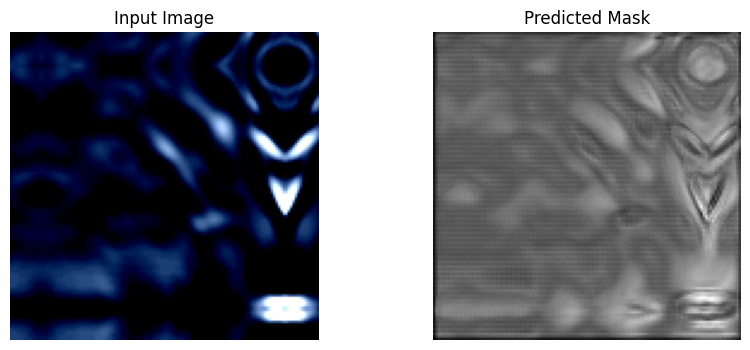

In [54]:
# %%
model = Unet()

# %%
x = torch.rand(1,3,128,128)

# %%
model(x)

# %%
import matplotlib.pyplot as plt

# Take a sample from your dataset (e.g., the first one)
sample_img, _ = train_dataset[10]  # (image, mask)
input_img = sample_img.unsqueeze(0)  # Add batch dimension

# Put model in eval mode and get output
model.eval()
with torch.no_grad():
    output = model(input_img)
    output = torch.sigmoid(output)
    output_mask = output.squeeze().cpu().numpy()

# Show input and output
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Input Image")
plt.imshow(sample_img.permute(1,2,0).cpu().numpy())
plt.axis('off')

plt.subplot(1,2,2)
plt.title("Predicted Mask")
plt.imshow(output_mask, cmap='gray')
plt.axis('off')
plt.show()


In [31]:
# # %%


# # %%
# # train_dir = r'D:\TGS Salt\train'


# # # %%
# # image_dir = 'train\images'
# # mask_dir = 'train\masks'
# # Get all image filenames (assuming masks have the same names)


# # # %%
# # image_transform = T.Compose([
# #     T.Resize((128, 128)),
# #     T.ToTensor(),
# #     T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# # ])

# # mask_transform = T.Compose([
# #     T.Resize((128, 128)),
# #     T.ToTensor(),  # will keep mask as [1, H, W]
# ])


# # %%
# # train_dataset = SaltDataset(image_dir,mask_dir,image_transform, mask_transform)
# # train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# # %%
# train_dataset[0][0].shape

# # %%
# import matplotlib.pyplot as plt

# # Pick one sample (e.g., the first one)
# image, mask = train_dataset[20]

# # Convert tensors to numpy arrays for visualization
# # For image: [C, H, W] -> [H, W, C]
# img_np = image.permute(1, 2, 0).cpu().numpy()
# # For mask: [1, H, W] -> [H, W]
# mask_np = mask.squeeze().cpu().numpy()

# # Undo normalization for visualization if needed
# # (If you used normalization in image_transform)
# img_np = img_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
# img_np = img_np.clip(0, 1)

# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.title("Image")
# plt.imshow(img_np)
# plt.axis('off')

# plt.subplot(1, 2, 2)
# plt.title("Mask")
# plt.imshow(mask_np, cmap='gray')
# plt.axis('off')

# plt.show()

# # %%




# # %%





SyntaxError: unmatched ']' (3397287256.py, line 24)

In [57]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [58]:
import torch
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


# Hyperparameters
num_epochs = 50
learning_rate = 1e-3
batch_size = 32  # As defined in your DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
save_path = "unet_salt_model.pth"

# Model, Loss, Optimizer
model = Unet().to(device)
criterion = nn.BCEWithLogitsLoss()  # Suitable for binary segmentation
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Training Loop with Loss Tracking
def train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs, device, save_path):
    best_loss = float('inf')
    train_losses = []  # To store average loss per epoch
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)

        for images, masks in loop:
            images, masks = images.to(device), masks.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Track loss
            running_loss += loss.item() * images.size(0)
            loop.set_postfix(loss=loss.item())

        # Compute and log epoch loss
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

        # Update learning rate
        scheduler.step(epoch_loss)

        # Save best model
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            torch.save(model.state_dict(), save_path)
            print(f"Saved model with loss: {best_loss:.4f}")

        # Visualize predictions every 5 epochs
        if (epoch + 1) % 5 == 0:
            model.eval()
            with torch.no_grad():
                sample_img, sample_mask = next(iter(train_loader))
                sample_img = sample_img[0].unsqueeze(0).to(device)  # Single image
                pred = torch.sigmoid(model(sample_img)).squeeze().cpu().numpy()
                
                # Denormalize image for visualization
                img_np = sample_img.squeeze().permute(1, 2, 0).cpu().numpy()
                img_np = img_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
                img_np = img_np.clip(0, 1)

                plt.figure(figsize=(10, 4))
                plt.subplot(1, 2, 1)
                plt.title("Input Image")
                plt.imshow(img_np)
                plt.axis('off')
                plt.subplot(1, 2, 2)
                plt.title(f"Predicted Mask (Epoch {epoch+1})")
                plt.imshow(pred, cmap='gray')
                plt.axis('off')
                plt.show()
            model.train()

    # Plot training loss
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.grid(True)
    plt.legend()
    plt.show()

# Assuming train_loader is already defined as in your code
train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs, device, save_path)

Epoch 1/50:   0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_31/3863230605.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(mask, dtype=torch.float32)
Epoch 1/50: 100%|██████████| 100/100 [00:44<00:00,  2.23it/s, loss=0.117]


Epoch 1/50, Loss: 0.3023
Saved model with loss: 0.3023


Epoch 2/50: 100%|██████████| 100/100 [00:47<00:00,  2.12it/s, loss=0.0413]


Epoch 2/50, Loss: 0.0705
Saved model with loss: 0.0705


Epoch 3/50: 100%|██████████| 100/100 [00:50<00:00,  1.99it/s, loss=0.0214]


Epoch 3/50, Loss: 0.0290
Saved model with loss: 0.0290


Epoch 4/50:  21%|██        | 21/100 [00:10<00:40,  1.96it/s, loss=0.0189]


KeyboardInterrupt: 

Eval from uploaded model

In [ ]:
device = 'cuda'

In [ ]:

model = Unet().to(device)
model.load_state_dict(torch.load('/kaggle/input/model-1/pytorch/default/1/unet_salt.pth', map_location='cpu'))
model.eval()

In [ ]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch
import torchvision.transforms as T

def rle_encode(mask):
    '''
    mask: numpy array, 1 - mask, 0 - background
    Returns run length as string formatted
    '''
    pixels = mask.flatten(order='F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

test_dir = '/kaggle/working/test_data/images'
test_files = sorted(os.listdir(test_dir))
results = []

# Use the same transforms as used for validation (resize, tensor, normalize)
val_transform = T.Compose([
    T.Resize((128, 128)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

model.eval()
for fname in tqdm(test_files):
    img_path = os.path.join(test_dir, fname)
    image = Image.open(img_path).convert('RGB')
    orig_size = image.size  # (width, height)
    input_tensor = val_transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        pred = model(input_tensor)
        pred = torch.sigmoid(pred)
        pred = (pred > 0.5).float()
        mask = pred.squeeze().cpu().numpy().astype(np.uint8)
    # Resize mask back to original size
    mask = Image.fromarray(mask)
    mask = mask.resize(orig_size, resample=Image.NEAREST)
    mask = np.array(mask)
    rle = rle_encode(mask)
    img_id = os.path.splitext(fname)[0]
    results.append({'id': img_id, 'rle_mask': rle})

# Save to CSV
df = pd.DataFrame(results)
df.to_csv('submission.csv', index=False)

In [ ]:
# import os
# import numpy as np 
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns  
# from PIL import Image
# import torch
# import torch.nn as nn
# from torch.utils.data import Dataset, DataLoader
# import torchvision.transforms as T
# import cv2

In [ ]:
# !unzip /kaggle/input/tgs-salt-identification-challenge/competition_data.zip

In [ ]:
# !unzip /kaggle/input/tgs-salt-identification-challenge/train.zip -d train_data
# !unzip /kaggle/input/tgs-salt-identification-challenge/test.zip -d test_data
# image_dir = '/kaggle/working/train_data/images'
# mask_dir = '/kaggle/working/train_data/masks'